# Generating reports from images inference interactive script

In [1]:
from collections import defaultdict

import albumentations as A
import cv2
import evaluate
import spacy
import torch
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/hermione/Documents/VLP/TUM/rgrg_pretrained/")
from src.full_model.report_generation_model import ReportGenerationModel
from src.full_model.train_full_model import get_tokenizer

cuda_device_to_see = 1
os.environ['CUDA_VISIBLE_DEVICES'] = f'{cuda_device_to_see}'
device = torch.device(f"cuda:{cuda_device_to_see}" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(cuda_device_to_see)
print("device: ", device)

BERTSCORE_SIMILARITY_THRESHOLD = 0.9
IMAGE_INPUT_SIZE = 512
MAX_NUM_TOKENS_GENERATE = 300
NUM_BEAMS = 4
mean = 0.471  # see get_transforms in src/dataset/compute_mean_std_dataset.py
std = 0.302

/home/hermione/miniconda3/envs/rgrg2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-14 17:41:15.008268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


device:  cuda:0
device:  cuda:0
device:  cuda:0
device:  cuda:1


In [2]:
def write_generated_reports_to_txt(images_paths, reports, generated_reports, generated_reports_txt_path):
    with open(generated_reports_txt_path, "w") as f:
        for image_path, ref, gen in zip(images_paths, reports, generated_reports):
            f.write(f"Image path: {image_path}\n")
            f.write(f"Generated report: {gen}\n\n")
            f.write(f"reports: {ref}\n\n")
            f.write("=" * 30)
            f.write("\n\n")

In [3]:
def get_report_for_image(model, image_tensor, tokenizer, bert_score, sentence_tokenizer):
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        output = model.generate(
            image_tensor.to(device, non_blocking=True),
            max_length=MAX_NUM_TOKENS_GENERATE,
            num_beams=NUM_BEAMS,
            early_stopping=True,
        )

    beam_search_output = output

    generated_sents_for_selected_regions = tokenizer.batch_decode(
        beam_search_output, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )  # list[str]

    """ generated_report = convert_generated_sentences_to_report(
        generated_sents_for_selected_regions, bert_score, sentence_tokenizer
    )   """# str
    generated_report = generated_sents_for_selected_regions
    return generated_report


def get_image_tensor(image_path):
    # cv2.imread by default loads an image with 3 channels
    # since we have grayscale images, we only have 1 channel and thus use cv2.IMREAD_UNCHANGED to read in the 1 channel
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # shape (3056, 2544)

    val_test_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=IMAGE_INPUT_SIZE, interpolation=cv2.INTER_AREA),
            A.PadIfNeeded(min_height=IMAGE_INPUT_SIZE, min_width=IMAGE_INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ]
    )

    transform = val_test_transforms(image=image)
    image_transformed = transform["image"]  # shape (1, 512, 512)
    image_transformed_batch = image_transformed.unsqueeze(0)  # shape (1, 1, 512, 512)

    return image_transformed_batch

def get_model(checkpoint_path):
    checkpoint = torch.load(
        checkpoint_path,
        map_location=torch.device("cpu"),
    )

    # if there is a key error when loading checkpoint, try uncommenting down below
    # since depending on the torch version, the state dicts may be different
    # checkpoint["model"]["object_detector.rpn.head.conv.weight"] = checkpoint["model"].pop("object_detector.rpn.head.conv.0.0.weight")
    # checkpoint["model"]["object_detector.rpn.head.conv.bias"] = checkpoint["model"].pop("object_detector.rpn.head.conv.0.0.bias")
    model = ReportGenerationModel(pretrain_without_lm_model=False)
    model.load_state_dict(checkpoint["model"])
    model.to(device, non_blocking=False)
    model.eval()

    del checkpoint

    return model


In [4]:
checkpoint_path = "/home/hermione/Documents/VLP/TUM/rgrg_pretrained/src/runs/full_model/run_21/saved_checkpoint/checkpoint_val_loss_2.060_overall_steps_258410.pt"
checkpoint_path = "/home/hermione/Documents/VLP/TUM/rgrg_pretrained/src/runs/full_model/run_20/checkpoints/checkpoint_val_loss_1.778_overall_steps_501150.pt"
checkpoint_path = "/home/hermione/Documents/VLP/TUM/rgrg_pretrained/src/runs/full_model/run_22/checkpoints/checkpoint_val_loss_2.034_overall_steps_309551.pt"
checkpoint_path  = "/home/hermione/Documents/VLP/TUM/rgrg_pretrained/src/runs/full_model/run_25/checkpoints/checkpoint_val_loss_2.604_overall_steps_161830.pt"
model = get_model(checkpoint_path)

print("Model instantiated.")

Model instantiated.


In [5]:
import pandas as pd
#train_final.to_csv("/home/hermione/Documents/data/rgrg/dataset-with-reference-reports/train_subset.csv",index=False)
val_final = pd.read_csv("/home/hermione/Documents/data/rgrg/dataset-with-reference-reports/test.csv")
val_final = pd.read_csv("/home/hermione/Documents/data/rgrg/dataset-with-reference-reports/test_card_vs_PE.csv")
val_final = pd.read_csv("/home/hermione/Documents/data/rgrg/dataset-with-reference-reports/train_subset_simplified.csv")
val_final

,subject_id,study_id,image_id,mimic_image_file_path,reference_report
0,10000980,57861150,5aa15ba6-55f5e96e-39cea686-7c3b28b2-b8c97a88,/home/hermione/Documents/data/physionet.org/fi...,Blunting of the costophrenic angles bilaterall...
1,10000980,58206436,54affd39-8bf24209-232bac8a-df6c277a-398ee8a5,/home/hermione/Documents/data/physionet.org/fi...,Severe cardiomegaly is likely accentuated due ...
2,10000980,59988438,925b9496-a956d7b2-05185e52-bb33313b-c06ee522,/home/hermione/Documents/data/physionet.org/fi...,Tiny bilateral pleural effusions are new since...
3,10001217,58913004,5e54fc9c-37c49834-9ac3b915-55811712-9d959d26,/home/hermione/Documents/data/physionet.org/fi...,Borderline size of the cardiac silhouette.
4,10002013,58054149,81bca127-0c416084-67f8033c-ecb26476-6d1ecf60,/home/hermione/Documents/data/physionet.org/fi...,A moderate left pleural effusion is new since ...
...,...,...,...,...,...
8095,12461334,59813777,9e882192-2860e30b-bc1729f0-f3dd9119-f4ef962a,/home/hermione/Documents/data/physionet.org/fi...,There is leftward effusion increased opacity i...
8096,12509458,51239211,964cc30a-f4549f80-99ecfb9c-d498554e-2db3da2d,/home/hermione/Documents/data/physionet.org/fi...,There is moderate cardiomegaly. There is left ...
8097,12738545,54211667,b80f54be-2c4c55f5-703ebbe3-d610f02f-9613a483,/home/hermione/Documents/data/physionet.org/fi...,"Trace bilateral pleural effusions are present,..."
8098,12855989,57262022,7f3b4261-424d9da8-250bdaca-42aac275-bc9d53a2,/home/hermione/Documents/data/physionet.org/fi...,Moderate cardiomegaly.


In [6]:
#ids = ["p10/p10001038/s58224503","p10/p10002428/s54831516"]
#im_ids = ["28fad2ac-d6001216-b4f72c5b-2d4d452e-17b6c9a5", "852306b6-02fc04aa-82d30dbf-0c2dd18d-5c9ef054"]
import os
im_ids = val_final["image_id"]
ids = "p"+val_final["subject_id"].astype(str) + os.sep +"s"+ val_final["study_id"].astype(str)
print(ids[:5])
im_ids = list(im_ids[:100])
ids = list(ids[:100])

0    p10000980/s57861150
1    p10000980/s58206436
2    p10000980/s59988438
3    p10001217/s58913004
4    p10002013/s58054149
dtype: object


In [7]:

# paths to the images that we want to generate reports for
images_paths = []
reports_paths = []
for n,i in enumerate(ids):
    images_paths.append(f"/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/{i}/{im_ids[n]}.jpg")
    reports_paths.append(f"/home/hermione/Documents/data/physionet.org/files/mimic-cxr/2.0.0/mimic-cxr-reports/files/p10/{i}.txt")

print(images_paths)
print(reports_paths)

['/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10000980/s57861150/5aa15ba6-55f5e96e-39cea686-7c3b28b2-b8c97a88.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10000980/s58206436/54affd39-8bf24209-232bac8a-df6c277a-398ee8a5.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10000980/s59988438/925b9496-a956d7b2-05185e52-bb33313b-c06ee522.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10001217/s58913004/5e54fc9c-37c49834-9ac3b915-55811712-9d959d26.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10002013/s58054149/81bca127-0c416084-67f8033c-ecb26476-6d1ecf60.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10002131/s52823782/051b7911-cb00aec9-0b309188-89803662-303ec278.jpg', '/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10002

0it [00:00, ?it/s]

p10000980/s57861150


1it [00:01,  1.29s/it]

p10000980/s58206436


2it [00:01,  1.40it/s]

generated reports:  ['The cardiac silhouette is mildly enlarged']
reference report:   WET READ: ___ ___ ___ 6:47 AM
  1. New mild pulmonary edema with persistent small bilateral pleural effusions.
  2. Severe cardiomegaly is likely accentuated due to low lung volumes and
  patient positioning.
  
 ______________________________________________________________________________
                                 FINAL REPORT
 EXAMINATION:  Chest radiograph.
 
 INDICATION:  ___F with wheezing and dyspnea.  Assess for pulmonary edema.
 
 TECHNIQUE:  Single portable upright frontal chest radiograph.
 
 COMPARISON:  ___ chest radiograph.  ___ chest radiograph.
 
 FINDINGS: 
 
 In comparison to study performed on of ___ there is new mild
 pulmonary edema with small bilateral pleural effusions.  Lung volumes have
 decreased with crowding of vasculature.  No pneumothorax.  Severe cardiomegaly
 is likely accentuated due to low lung volumes and patient positioning.
 
 IMPRESSION: 
 
 1. New mild pul

3it [00:01,  1.80it/s]

p10001217/s58913004


4it [00:02,  2.13it/s]

p10002013/s58054149


5it [00:02,  2.37it/s]

p10002131/s52823782


6it [00:03,  2.44it/s]

p10002428/s50027225


7it [00:03,  2.64it/s]

p10002428/s50444997


8it [00:03,  2.80it/s]

p10002428/s54020701


9it [00:03,  2.93it/s]

p10002428/s54831516


10it [00:04,  2.99it/s]

p10002428/s55758034


11it [00:04,  3.02it/s]

p10002428/s56597576


12it [00:04,  3.04it/s]

p10002428/s56836542


13it [00:05,  3.08it/s]

p10002428/s57506266


14it [00:05,  3.14it/s]

p10002428/s57887188


15it [00:05,  3.15it/s]

p10002428/s57961288


16it [00:06,  3.16it/s]

p10002428/s57961288


17it [00:06,  3.19it/s]

p10002428/s58601917


18it [00:06,  3.16it/s]

p10002428/s58838312


19it [00:07,  3.18it/s]

p10002428/s58851198


20it [00:07,  3.01it/s]

p10002428/s59098825


21it [00:07,  3.05it/s]

p10002428/s59659695


22it [00:08,  2.97it/s]

p10003299/s50536653


23it [00:08,  3.02it/s]

p10003299/s57344656


24it [00:08,  2.93it/s]

p10003400/s52822559


25it [00:09,  2.96it/s]

p10003400/s54050001


26it [00:09,  2.77it/s]

p10003400/s55177950


27it [00:09,  2.78it/s]

p10003400/s59336915


28it [00:10,  2.76it/s]

p10003502/s51180958


29it [00:10,  2.82it/s]

p10003502/s52139270


30it [00:10,  2.88it/s]

p10003502/s52309364


31it [00:11,  2.83it/s]

p10003502/s53282957


32it [00:11,  2.85it/s]

p10003502/s57641661


33it [00:12,  2.85it/s]

p10003502/s57812613


34it [00:12,  2.94it/s]

p10004235/s57318275


35it [00:12,  2.95it/s]

p10004457/s55439624


36it [00:13,  3.04it/s]

p10005024/s53950795


37it [00:13,  2.93it/s]

p10005749/s54040624


38it [00:13,  2.89it/s]

p10005749/s54060141


39it [00:14,  2.85it/s]

p10005749/s57249718


40it [00:14,  2.86it/s]

p10007795/s54054513


41it [00:14,  2.87it/s]

p10007795/s54054513


42it [00:15,  2.94it/s]

p10007795/s54492585


43it [00:15,  3.03it/s]

p10007795/s58754452


44it [00:15,  3.01it/s]

p10007795/s58754452


45it [00:16,  2.94it/s]

p10007928/s59796203


46it [00:16,  2.93it/s]

p10008493/s54180175


47it [00:16,  2.83it/s]

p10010440/s57403810


48it [00:17,  2.82it/s]

p10011365/s59373787


49it [00:17,  2.93it/s]

p10011668/s50539024


50it [00:17,  2.94it/s]

p10011668/s57069032


51it [00:18,  2.98it/s]

p10012292/s50854114


52it [00:18,  3.13it/s]

p10012292/s51979091


53it [00:18,  3.13it/s]

p10012292/s52412975


54it [00:19,  3.18it/s]

p10012292/s52500232


55it [00:19,  3.17it/s]

p10013502/s59527128


56it [00:19,  3.21it/s]

p10013653/s50073683


57it [00:19,  3.28it/s]

p10013653/s50073683


58it [00:20,  3.34it/s]

p10013653/s53212555


59it [00:20,  3.18it/s]

p10013653/s53212555


60it [00:20,  3.02it/s]

p10013653/s55563991


61it [00:21,  2.96it/s]

p10014729/s51377970


62it [00:21,  2.93it/s]

p10014729/s53646444


63it [00:22,  2.89it/s]

p10014729/s54116558


64it [00:22,  2.83it/s]

p10014729/s54258430


65it [00:22,  2.86it/s]

p10014729/s56982861


66it [00:23,  2.83it/s]

p10015931/s52545203


67it [00:23,  2.76it/s]

p10015931/s53883707


68it [00:23,  2.84it/s]

p10015931/s57962525


69it [00:24,  2.84it/s]

p10016742/s54544825


70it [00:24,  2.90it/s]

p10019003/s53307223


71it [00:24,  3.08it/s]

p10019568/s59892630


72it [00:25,  3.02it/s]

p10021666/s51474885


73it [00:25,  3.00it/s]

p10021927/s58800461


74it [00:25,  3.00it/s]

p10021938/s50014720


75it [00:26,  3.01it/s]

p10021938/s55463845


76it [00:26,  2.97it/s]

p10022041/s55830708


77it [00:26,  3.01it/s]

p10022041/s55830708


78it [00:27,  3.06it/s]

p10022041/s56775341


79it [00:27,  2.97it/s]

p10022041/s56775341


80it [00:27,  2.96it/s]

p10023117/s52880779


81it [00:28,  3.00it/s]

p10023117/s53372543


82it [00:28,  2.95it/s]

p10023117/s54051348


83it [00:28,  2.90it/s]

p10023117/s54051348


84it [00:29,  2.96it/s]

p10023117/s54404075


85it [00:29,  2.87it/s]

p10023117/s56007252


86it [00:29,  2.92it/s]

p10024982/s50980427


87it [00:30,  2.97it/s]

p10024982/s52295645


88it [00:30,  2.91it/s]

p10024982/s54438313


89it [00:30,  2.87it/s]

p10024982/s54981300


90it [00:31,  2.81it/s]

p10024982/s57517987


91it [00:31,  2.84it/s]

p10024982/s57639867


92it [00:31,  2.90it/s]

p10024982/s58575944


93it [00:32,  2.97it/s]

p10024982/s58575944


94it [00:32,  2.99it/s]

p10025139/s50196457


95it [00:32,  3.03it/s]

p10031687/s56022717


96it [00:33,  2.94it/s]

p10033290/s53250799


97it [00:33,  2.96it/s]

p10039272/s50589184


98it [00:33,  3.08it/s]

p10039272/s50821222


99it [00:34,  3.07it/s]

p10039272/s56135137


100it [00:34,  2.89it/s]


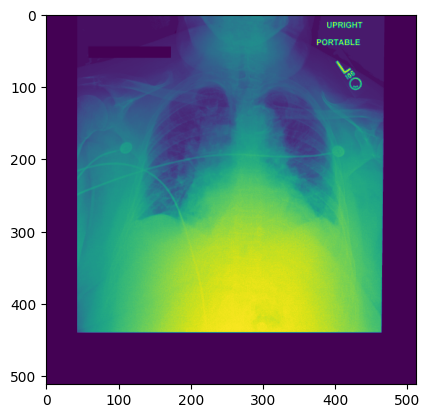

In [8]:
generated_reports_txt_path = "inference/generated_reports_run25.txt"
generated_reports = []
ref_reports = []
bert_score = evaluate.load("bertscore")
sentence_tokenizer = spacy.load("en_core_web_trf")
tokenizer = get_tokenizer()

# if you encounter a spacy-related error, try upgrading spacy to version 3.5.3 and spacy-transformers to version 1.2.5
# pip install -U spacy
# pip install -U spacy-transformers

for i, image_path in tqdm(enumerate(images_paths)):
    print(ids[i])
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image_tensor = get_image_tensor(image_path)  # shape (1, 1, 512, 512)
    generated_report = get_report_for_image(model, image_tensor, tokenizer, bert_score, sentence_tokenizer)
    generated_reports.append(generated_report)
    with open(reports_paths[i]) as f:
        ref_reports.append(f.read())

#for i, image_path in tqdm(enumerate(images_paths)):
    #show
    if i ==1:
        #plt.imshow(image_tensor.detach().cpu().numpy()[0][0])
        plt.imshow(image, cmap='gray')
        print("generated reports: ", generated_reports[i])
        print("reference report: ", ref_reports[i])

write_generated_reports_to_txt(images_paths, ref_reports, generated_reports, generated_reports_txt_path)

(-0.5, 1735.5, 2021.5, -0.5)

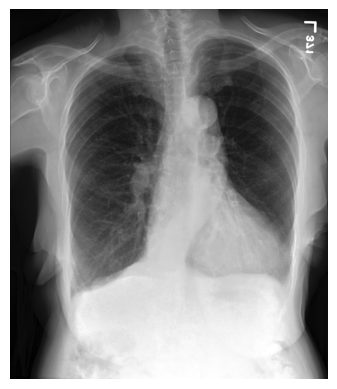

In [30]:
#load im

path = "/home/hermione/Documents/data/physionet.org/files/mimic-cxr-jpg/2.0.0/files/p10/p10032409/s55250890/35b006d3-53b9d561-d46bbbe3-69a82eaa-677f1241.jpg"

image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
plt.imshow(image, cmap='gray')
plt.axis("off")